In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


# Problem description
We are provided with daily historical sales data (in a day by day format) and the task is to forecast the total amount of products sold in every shop for the test set, which is dated to the next month.

Evaluation will be done with RMSE. One thing caught my attention: True target values are clipped into `[0,20]`.

# But first, some conventions

- First it's worth noting that all data is under `../.data`. 
- We will use a Makefile to describe the execution steps and dependency graph of the whole analysis. The goal is to be able to run `make final-submission` to generate the final submission from scratch.
- Notebooks are only used for exploration and documentation. The final result is coded separately (inside `../src`) from the experience gathered through notebooks.

In [2]:
import zipfile
with zipfile.ZipFile(os.path.join(RAW_DATA_DIR, 'competitive-data-science-predict-future-sales.zip'), 'r') as datasets_file:
    item_categories = pd.read_csv(datasets_file.open('item_categories.csv'))
    items = pd.read_csv(datasets_file.open('items.csv'))
    sales_train = pd.read_csv(datasets_file.open('sales_train.csv'))
    sample_submission = pd.read_csv(datasets_file.open('sample_submission.csv'))
    shops = pd.read_csv(datasets_file.open('shops.csv'))
    test_set = pd.read_csv(datasets_file.open('test.csv'))

# Training/test sets

In [3]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
test_set.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [6]:
test_set.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


About the clipping on the true targets range: let's see if this also happens on the train set.

In [7]:
# notice `date_block_num` is actually related to the month
sales_train_by_month = sales_train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
sales_train_by_month.rename(columns={'item_cnt_day': 'item_cnt'}, inplace=True)
sales_train_by_month.describe()

,date_block_num,shop_id,item_id,item_cnt
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.466479e+01,3.280585e+01,1.068099e+04,2.267200e+00
std,9.542322e+00,1.653701e+01,6.238883e+03,8.649882e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01
25%,6.000000e+00,2.100000e+01,5.045000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.606000e+04,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.253000e+03


<AxesSubplot:>

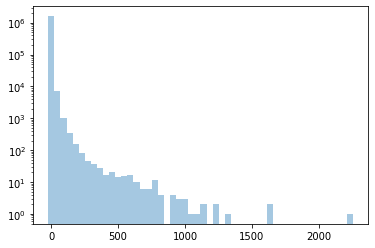

In [8]:
sns.distplot(sales_train_by_month['item_cnt'].values, hist_kws={'log':True}, kde=False, norm_hist=False)

Results near zero are orders of magnitude larger than the rest, but let's keep in mind this is before the clipping. Let's clip it and see how this looks like

In [9]:
sales_train_by_month_clipped = sales_train_by_month.copy()
sales_train_by_month_clipped['item_cnt'] = np.clip(sales_train_by_month_clipped['item_cnt'], 0, 20)
sales_train_by_month_clipped.describe()

,date_block_num,shop_id,item_id,item_cnt
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.466479e+01,3.280585e+01,1.068099e+04,2.022806e+00
std,9.542322e+00,1.653701e+01,6.238883e+03,2.577964e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,2.100000e+01,5.045000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.606000e+04,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.000000e+01


<AxesSubplot:>

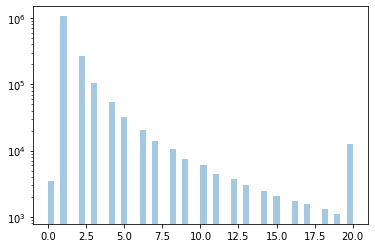

In [10]:
sns.distplot(sales_train_by_month_clipped['item_cnt'].values, hist_kws={'log':True}, kde=False, norm_hist=False)

Still not pretty, decaying orders of magnitude until it reaches 20. Good to keep that in mind (maybe we're better off predicting only the extremities well?). Either way, this logic will be available as a script.

# Train/Test consistency

We need to generate the train set from a list of historical events. The problem with that is we may end up with a train set that doesn't come from the same probability distribution as the test set samples.

To test this, let's look at the distribution of item id + shop id pairs on each data set.

<AxesSubplot:xlabel='shop_id'>

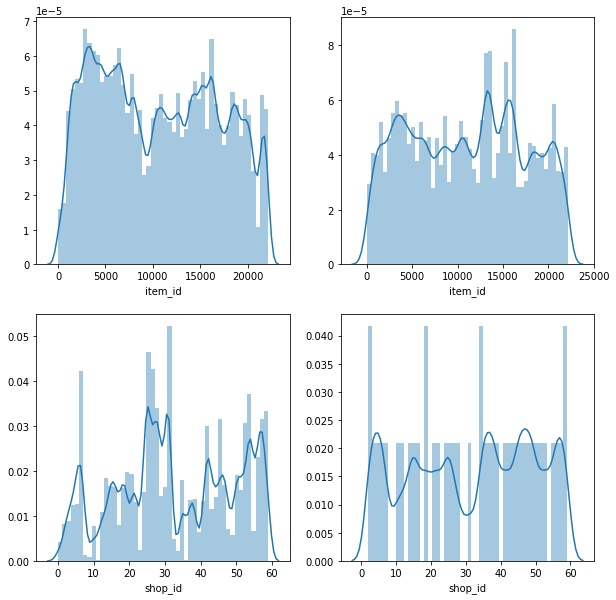

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(sales_train_by_month_clipped['item_id'], ax=axes[0][0])
sns.distplot(test_set['item_id'], ax=axes[0][1])
sns.distplot(sales_train_by_month_clipped['shop_id'], ax=axes[1][0])
sns.distplot(test_set['shop_id'], ax=axes[1][1])

Pretty different, specially the shops. Let's look at the last month of the train data, since time might explain this effect.

<AxesSubplot:xlabel='shop_id', ylabel='count'>

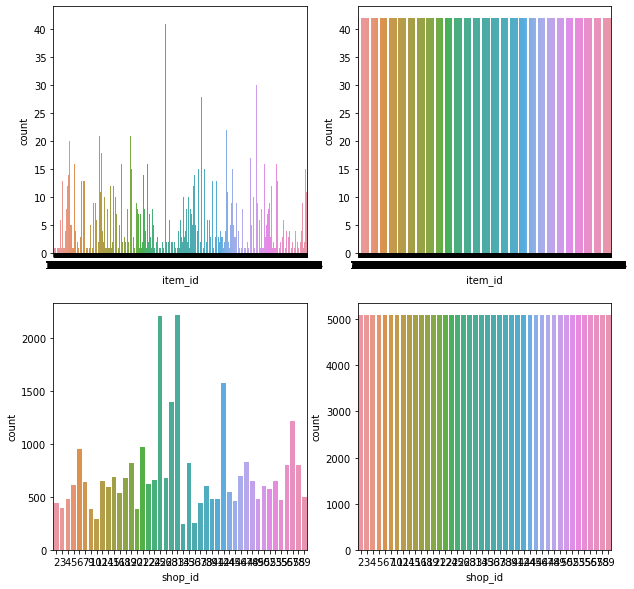

In [26]:
sales_train_last_month = sales_train_by_month_clipped[sales_train_by_month_clipped['date_block_num'] == sales_train_by_month_clipped['date_block_num'].max()]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(data=sales_train_last_month, x='item_id', ax=axes[0][0])
sns.countplot(data=test_set, x='item_id', ax=axes[0][1])
sns.countplot(data=sales_train_last_month, x='shop_id', ax=axes[1][0])
sns.countplot(data=test_set, x='shop_id', ax=axes[1][1])

Yup, big random dataset on test set. Also there's some shops and items that are not present. Let's check the intersections

In [61]:
def intersection_cnt(a, b, idxs):
    a_uniques = a[idxs].drop_duplicates()
    b_uniques = b[idxs].drop_duplicates()
    intersection = pd.merge(a_uniques, b_uniques, on=idxs)[idxs].drop_duplicates().shape[0]
    return {'intersection_cnt': intersection,
            'on A and not on B': intersection / a_uniques.shape[0],
            'on B and not on A': intersection / b_uniques.shape[0]}

In [62]:
intersection_cnt(sales_train, test_set, ['item_id', 'shop_id'])

{'intersection_cnt': 111404,
 'on A and not on B': 0.2626684648829116,
 'on B and not on A': 0.520093370681606}

In [63]:
intersection_cnt(sales_train_last_month, test_set, ['item_id', 'shop_id'])

{'intersection_cnt': 28680,
 'on A and not on B': 0.9095810472233675,
 'on B and not on A': 0.13389355742296918}

In [64]:
intersection_cnt(sales_train, test_set, ['item_id'])

{'intersection_cnt': 4737,
 'on A and not on B': 0.21722382721144587,
 'on B and not on A': 0.9288235294117647}

In [65]:
intersection_cnt(sales_train_last_month, test_set, ['item_id'])

{'intersection_cnt': 3991,
 'on A and not on B': 0.7372990947718455,
 'on B and not on A': 0.7825490196078432}

In [66]:
intersection_cnt(sales_train, test_set, ['shop_id'])

{'intersection_cnt': 42, 'on A and not on B': 0.7, 'on B and not on A': 1.0}

In [68]:
intersection_cnt(sales_train_last_month, test_set, ['shop_id'])

{'intersection_cnt': 42,
 'on A and not on B': 0.9545454545454546,
 'on B and not on A': 1.0}

# Benchmark submission

The sample submission uses the counts for the last month, and imputs the missing values with zero.

In [24]:
solution_benchmark = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id']).fillna(0)
solution_benchmark.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,4.418487,31.642857,11019.398627,0.255649,107099.500000
std,11.237777,17.561933,6252.644590,1.089856,61834.358168
min,0.000000,2.000000,30.000000,0.000000,0.000000
25%,0.000000,16.000000,5381.500000,0.000000,53549.750000
50%,0.000000,34.500000,11203.000000,0.000000,107099.500000
75%,0.000000,47.000000,16071.500000,0.000000,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [25]:
solution_benchmark[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(TMP_DIR, 'benchmark-submission.csv'), index=False)

In [24]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-submission.csv -m 'benchmark reproduction' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 2.14M/2.14M [00:06<00:00, 336kB/s] 


The score is as expected: 1.16777. Let's try and beat that with some simple heuristics. Instead of replacing NaNs with zeros, let's replace them with the mean of the other items counts.

In [25]:
benchmark_mean_imputation = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id'])
benchmark_mean_imputation.fillna(benchmark_mean_imputation['item_cnt'].mean(), inplace=True)
benchmark_mean_imputation.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,6.072183,31.642857,11019.398627,1.909344,107099.500000
std,10.587572,17.561933,6252.644590,0.874654,61834.358168
min,1.909344,2.000000,30.000000,0.000000,0.000000
25%,1.909344,16.000000,5381.500000,1.909344,53549.750000
50%,1.909344,34.500000,11203.000000,1.909344,107099.500000
75%,1.909344,47.000000,16071.500000,1.909344,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [26]:
benchmark_mean_imputation[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(TMP_DIR, 'benchmark-mean-imputation.csv'), index=False)

In [27]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-mean-imputation.csv -m 'benchmark reproduction replacing zeros with mean' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 4.62M/4.62M [00:13<00:00, 348kB/s] 


Surprise surprise: `1.99060`. Even though the mean was relatively low (~1.909). Let's try with the median.

In [28]:
benchmark_median_imputation = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id'])
benchmark_median_imputation.fillna(benchmark_median_imputation['item_cnt'].median(), inplace=True)
benchmark_median_imputation.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,5.284594,31.642857,11019.398627,1.121755,107099.500000
std,10.897239,17.561933,6252.644590,0.927854,61834.358168
min,1.000000,2.000000,30.000000,0.000000,0.000000
25%,1.000000,16.000000,5381.500000,1.000000,53549.750000
50%,1.000000,34.500000,11203.000000,1.000000,107099.500000
75%,1.000000,47.000000,16071.500000,1.000000,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [29]:
benchmark_median_imputation[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(TMP_DIR, 'benchmark-median-imputation.csv'), index=False)

In [30]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-median-imputation.csv -m 'benchmark reproduction replacing zeros with median' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 2.14M/2.14M [00:06<00:00, 335kB/s] 


Better than before: `1.39120`. Still worse than zero-imputation. Now let's try setting everything to zero.

In [27]:
zero_submission = pd.DataFrame({'ID': test_set['ID'], 'item_cnt_month': 0})
zero_submission.to_csv(os.path.join(TMP_DIR, 'benchmark-zeros-only.csv'), index=False)

In [28]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-zeros-only.csv -m 'zeros only' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 1.73M/1.73M [00:25<00:00, 70.2kB/s]


1.25011. Not much insight from this other than knowing the dataset is also very skewed to zero on the test set.

# Choosing our train set

We now know the ids on the test set are probably randomly generated. We also know the test set is skewed to zero. This makes me want to use the ids from the test set to train.

The problem with this approach is that the test set is pretty big (~214k rows). We won't be able to use the test set ids for each month or we'll have a train set of $33 x 214,000 = 7,062,000$ rows, which is too big for us right now. On the other hand, I want (further down the line) to have at least a two-level ensemble, so I need enough data to generate oof predictions and be able to test the 2nd layer on.

In [26]:
def train_set_month(m):
    df = test_set[['item_id', 'shop_id']].copy()
    df['date_block_num'] = m
    return df
train_set = pd.concat([train_set_month(m) for m in range(1, 34)]).merge(sales_train_by_month, on=['item_id', 'shop_id', 'date_block_num'], how='left').fillna(0)
train_set.describe()

,item_id,shop_id,date_block_num,item_cnt
count,7.068600e+06,7.068600e+06,7.068600e+06,7.068600e+06
mean,1.101940e+04,3.164286e+01,1.700000e+01,2.259512e-01
std,6.252630e+03,1.756189e+01,9.521905e+00,3.369709e+00
min,3.000000e+01,2.000000e+00,1.000000e+00,-4.000000e+00
25%,5.381500e+03,1.600000e+01,9.000000e+00,0.000000e+00
50%,1.120300e+04,3.450000e+01,1.700000e+01,0.000000e+00
75%,1.607150e+04,4.700000e+01,2.500000e+01,0.000000e+00
max,2.216700e+04,5.900000e+01,3.300000e+01,2.253000e+03


In [27]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068600 entries, 0 to 7068599
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   item_id         int64  
 1   shop_id         int64  
 2   date_block_num  int64  
 3   item_cnt        float64
dtypes: float64(1), int64(3)
memory usage: 269.6 MB


Yikes. 269MB for just the ids and labels. Let's see what we can do later.

# Mean from MSE

We can extract the mean of a dataset from the MSE.

$\bar{m} = \dfrac{1}{N} \sum_{i=1}^{N} y_i$

$\text{MSE}_0 = \dfrac{1}{N} \sum_{i=1}^{N} (y_i - 0) ^ 2 = \dfrac{1}{N} \sum_{i=1}^{N} y_i ^ 2$

$\text{MSE}_1 = \dfrac{1}{N} \sum_{i=1}^{N} (y_i - 1) ^ 2 = \dfrac{1}{N} \sum_{i=1}^{N} (y_i ^ 2 - 2y_i + 1) = \dfrac{1}{N} \left( \sum_{i=1}^{N} y_i ^ 2 - 2 \sum_{i=1}^{N} y_i + N \right) = \text{MSE}_0 - 2 \bar{m} + 1$

$\therefore \bar{m} = \dfrac{\text{MSE}_0 - \text{MSE}_1 + 1}{2}$

If we run this on the public LB we can get the mean of the test set data. 